# Workbook information

*   This notebook creates a regression analysis of an insurance dataset from the book `Machine Learning with R` (https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv)





In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Importing the helper_functions file
import os

if not os.path.exists('helper_functions.py'):
  !wget https://raw.githubusercontent.com/DavAll22/Extra-Code/main/helper_functions_TF.py
else:
  print("[INFO] 'helper_functions_TF.py' already exists, skipping download.")

--2023-06-08 08:13:37--  https://raw.githubusercontent.com/DavAll22/Extra-Code/main/helper_functions_TF.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13751 (13K) [text/plain]
Saving to: ‘helper_functions_TF.py’

helper_functions_TF 100%[===================>]  13.43K  --.-KB/s    in 0.001s  

2023-06-08 08:13:37 (23.3 MB/s) - ‘helper_functions_TF.py’ saved [13751/13751]



# Making the dataset

In [2]:
# Read insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [3]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# Transforming non-numerical values using OneHotEncoder and normalising numerical columns with different ranges with MinMaxScalar
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Creating a column transformer to normalise and preprocess data
ct = make_column_transformer(
    (MinMaxScaler(), ['age', 'bmi', 'children']), # normalises values to be between 0 and 1
    (OneHotEncoder(handle_unknown='ignore'), ['sex', 'smoker', 'region'])
)

Note: You can also do `pd.get_dummies(insurance)` to get the one-hot encoded values, however we want to also normalise it, so are using a column transformer.

In [5]:
# Creating training and test sets
from sklearn.model_selection import train_test_split

# Create X and y
X = insurance.drop('charges', axis=1)
y = insurance['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the column transformer to training data only (prevent data leakage)
ct.fit(X_train)

# Transform training and test data with normalisation and one-hot encoding
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

In [6]:
X_train_normal.shape, X_train.shape

((1070, 11), (1070, 6))

One-hot encoding the non-numerical columns increases the size of the dataframe

# Model creation

In [7]:
# Set random seed
tf.random.set_seed(42)

# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(300),
    tf.keras.layers.Dense(200),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(50),
    tf.keras.layers.Dense(1)
])

# Compiling the model
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mae'])

# Fit the model
model_history = model.fit(tf.expand_dims(X_train_normal, axis=1), # Creating an additional column in normalised training data
                          y_train,
                          epochs=200,
                          validation_data=(X_test_normal, y_test),
                          verbose=0,)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 300)            3600      
                                                                 
 dense_1 (Dense)             (None, 1, 200)            60200     
                                                                 
 dense_2 (Dense)             (None, 1, 100)            20100     
                                                                 
 dense_3 (Dense)             (None, 1, 50)             5050      
                                                                 
 dense_4 (Dense)             (None, 1, 1)              51        
                                                                 
Total params: 89,001
Trainable params: 89,001
Non-trainable params: 0
_________________________________________________________________


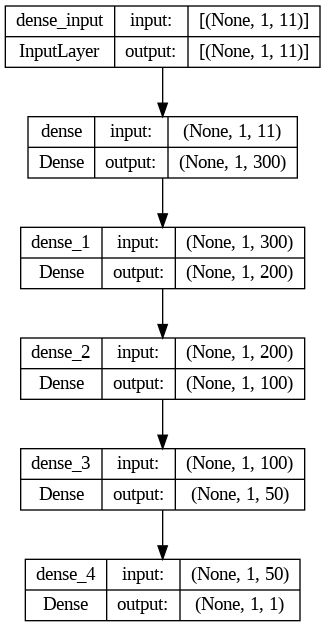

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

# Evaluation

In [10]:
loss_train, mae_train = model.evaluate(X_train_normal, y_train)
print(f'Model loss on train set: {loss_train}')
print(f'Model MAE on train set: {mae_train}')

34/34 [==============================] - 0s 2ms/step - loss: 3476.6172 - mae: 3476.6172
Model loss on train set: 3476.6171875
Model MAE on train set: 3476.6171875


In [11]:
loss_test, mae_test = model.evaluate(X_test_normal, y_test)
print(f'Model loss on test set: {loss_test}')
print(f'Model MAE on test set: {mae_test}')

9/9 [==============================] - 0s 2ms/step - loss: 3168.4385 - mae: 3168.4385
Model loss on test set: 3168.4384765625
Model MAE on test set: 3168.4384765625


Loss and MAE are the same value as the model was initialised with the loss function being mae, as well as the metric MAE added after.

# Loss curves

Text(0.5, 0, 'epochs')

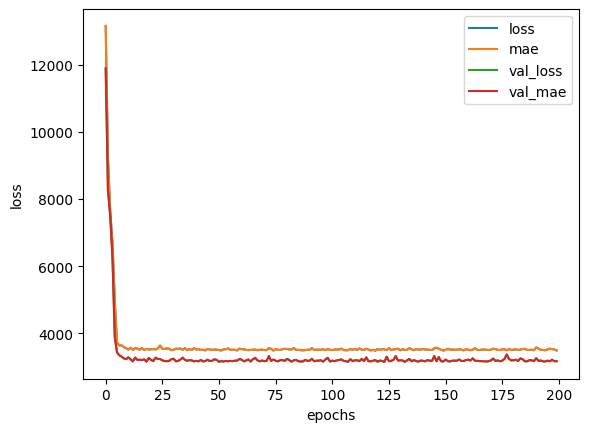

In [12]:
pd.DataFrame(model_history.history).plot()
plt.ylabel('loss')
plt.xlabel('epochs')

In [21]:
from helper_functions_TF import plot_loss_curves_regression
plot_loss_curves_regression(model_history)

ImportError: ignored

# Predictions

In [22]:
y_probs = model.predict(X_test_normal)
y_probs[:10]

9/9 [==============================] - 0s 8ms/step


array([[ 9181.4375],
       [ 5907.214 ],
       [44407.445 ],
       [ 9119.113 ],
       [32125.312 ],
       [ 5711.929 ],
       [ 1017.9868],
       [13283.438 ],
       [ 3472.12  ],
       [10055.648 ]], dtype=float32)

In [23]:
y_test[:10]

764      9095.06825
887      5272.17580
890     29330.98315
1293     9301.89355
259     33750.29180
1312     4536.25900
899      2117.33885
752     14210.53595
1286     3732.62510
707     10264.44210
Name: charges, dtype: float64